# 1. Dependencies

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import category_encoders as ce
from keras.layers import *
from keras.applications import *
from keras.models import *
from keras.utils import *
import keras.metrics as metrics

Using TensorFlow backend.


# 2. Data Preprocessing and Pipeline 

In [26]:
# reading  and analyzing the data files
train_df = pd.read_excel("../data/Train_dataset.xlsx", sheet_name="Train_dataset")
test_df = pd.read_excel("../data/Test_dataset.xlsx", sheet_name="Test_dataset")

## 2.1 Cleaning the data (Removing the redundant/irrelevant variable)

In [27]:
'''People_Id, Name does not determine(or might be but its rarest) Infect_prod, Designation and Gender are same '''

'People_Id, Name does not determine(or might be but its rarest) Infect_prod, Designation and Gender are same '

In [28]:
train_df = train_df.drop(columns=['Name', 'Designation', 'people_ID'], axis=1);
test_df = test_df.drop(columns=['Name', 'Designation', 'people_ID'], axis=1)

In [29]:
train_df.head(5)

,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,Bhubaneshwar,Female,YES,1.0,Farmer,Public,2,0,Hypertension,68,...,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,Bhubaneshwar,Female,YES,2.0,Farmer,Walk,2,0,Diabetes,64,...,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,Bhubaneshwar,Female,NO,1.0,Cleaner,Public,2,0,None,19,...,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,Bhubaneshwar,Female,YES,1.0,Driver,Car,2,0,Coronary Heart Disease,33,...,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,Bhubaneshwar,Female,NO,2.0,Manufacturing,Car,2,0,Diabetes,23,...,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


## 2.2 EDA (Data Visualization)

### 2.2.1 Missing data visualisation, White fields indicate NaNs

In [30]:
train_copy = train_df.replace("nan", np.nan)

In [31]:
test_copy = test_df.replace("nan", np.nan)

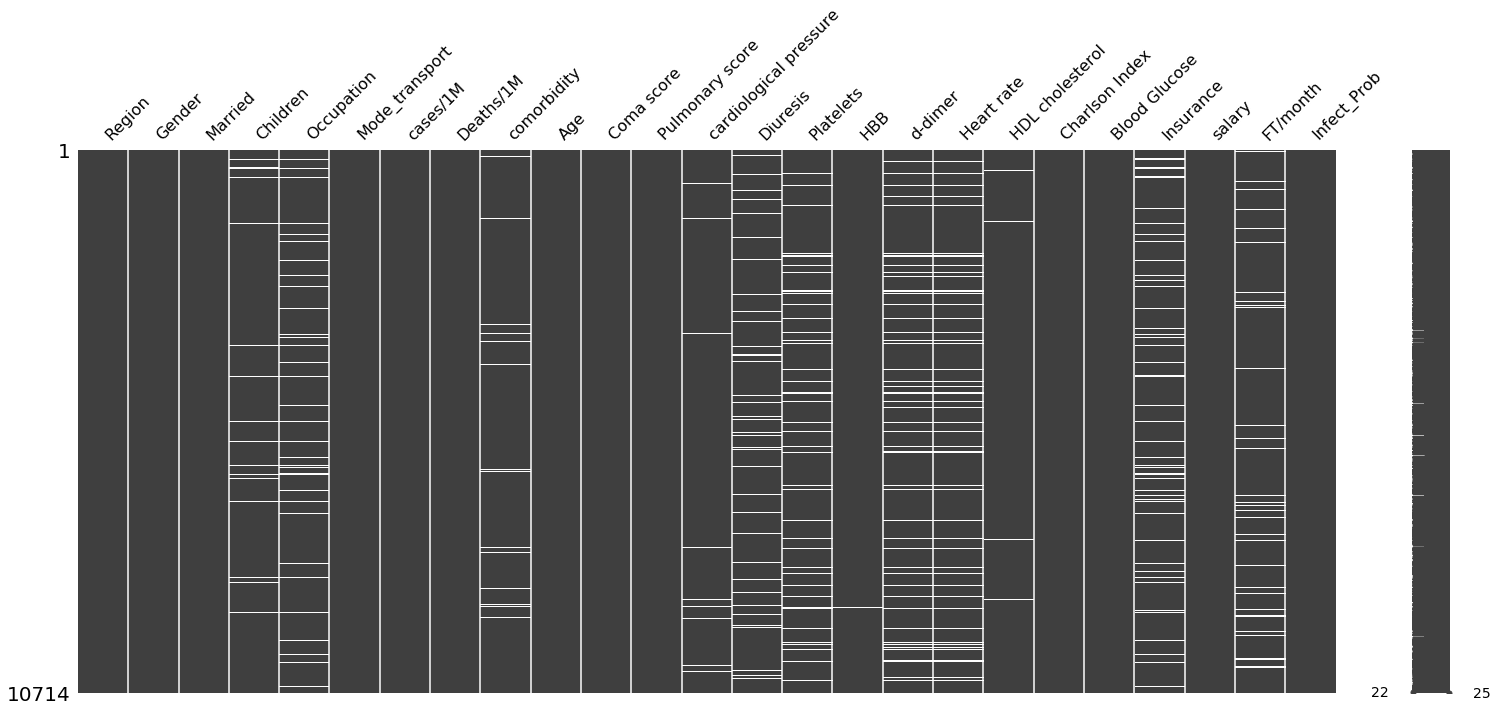

In [32]:
# missing values in training data
msno.matrix(train_copy);

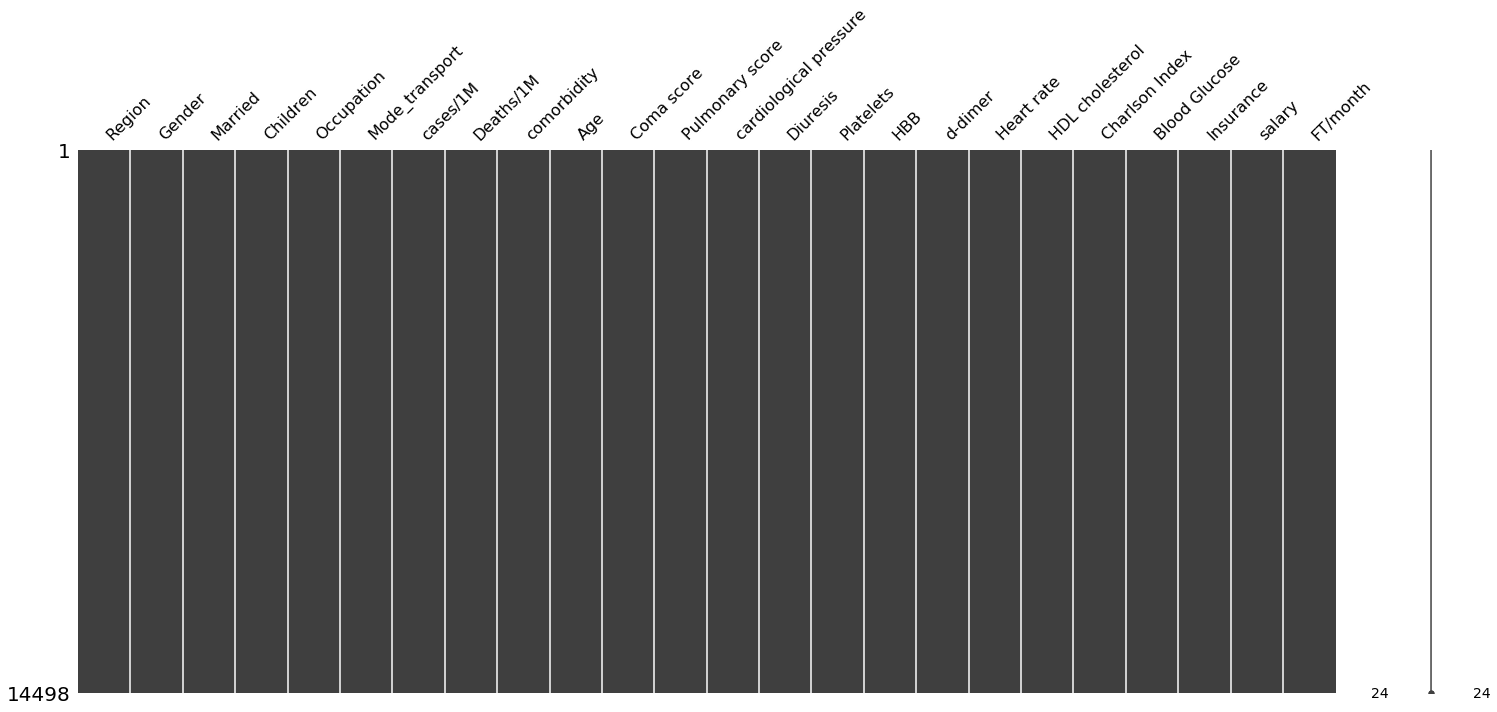

In [33]:
# missing values in test data (Its unlikely that there will be  any missing values in test data but lets c)
msno.matrix(test_df);

### 2.2.2 Correlation heatmap

In [34]:
# missingno heatmap measures nullity correlation, how the presence or absence or a variable
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 
# (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears 
# the other definitely also does).

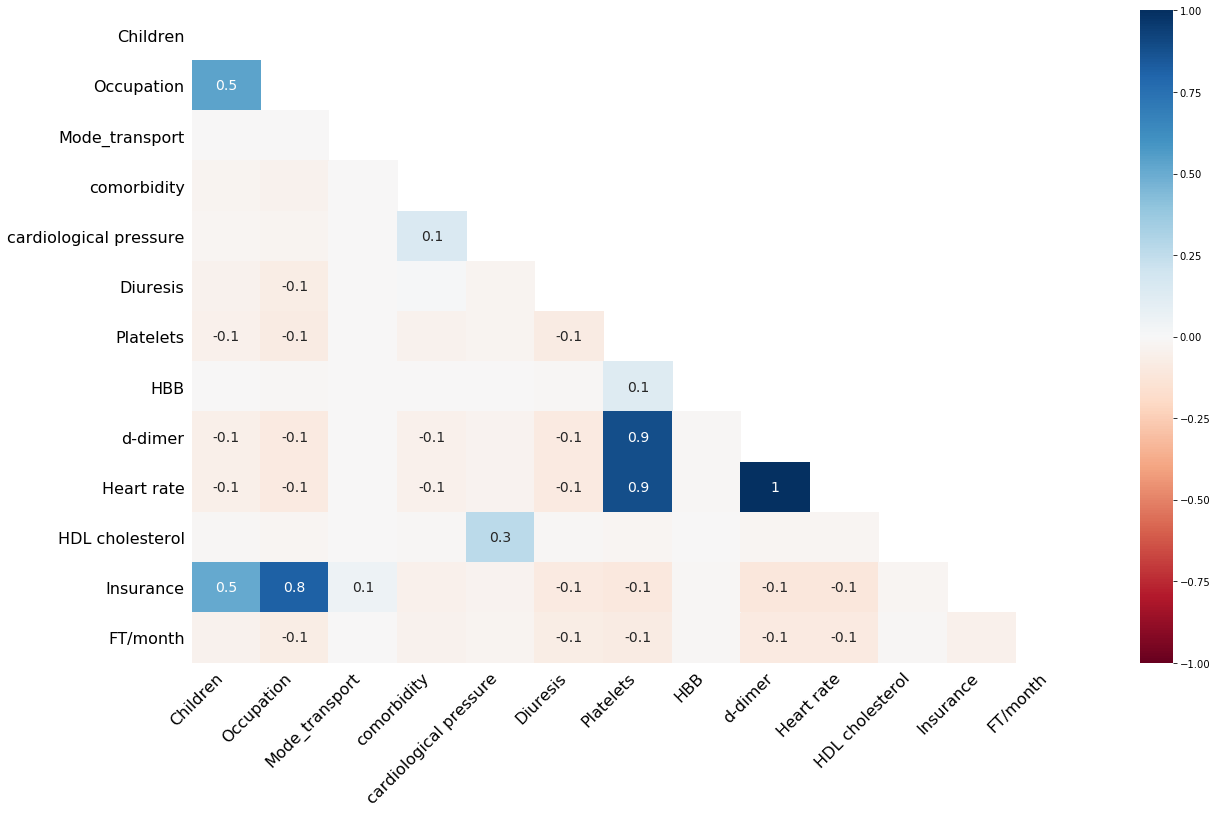

In [35]:
msno.heatmap(train_copy);

### 2.2.3 Dendrogram

In [36]:
### The dendrogram allows us to more fully correlate variable completion, 
### revealing trends deeper than the pairwise ones visible in the correlation heatmap:

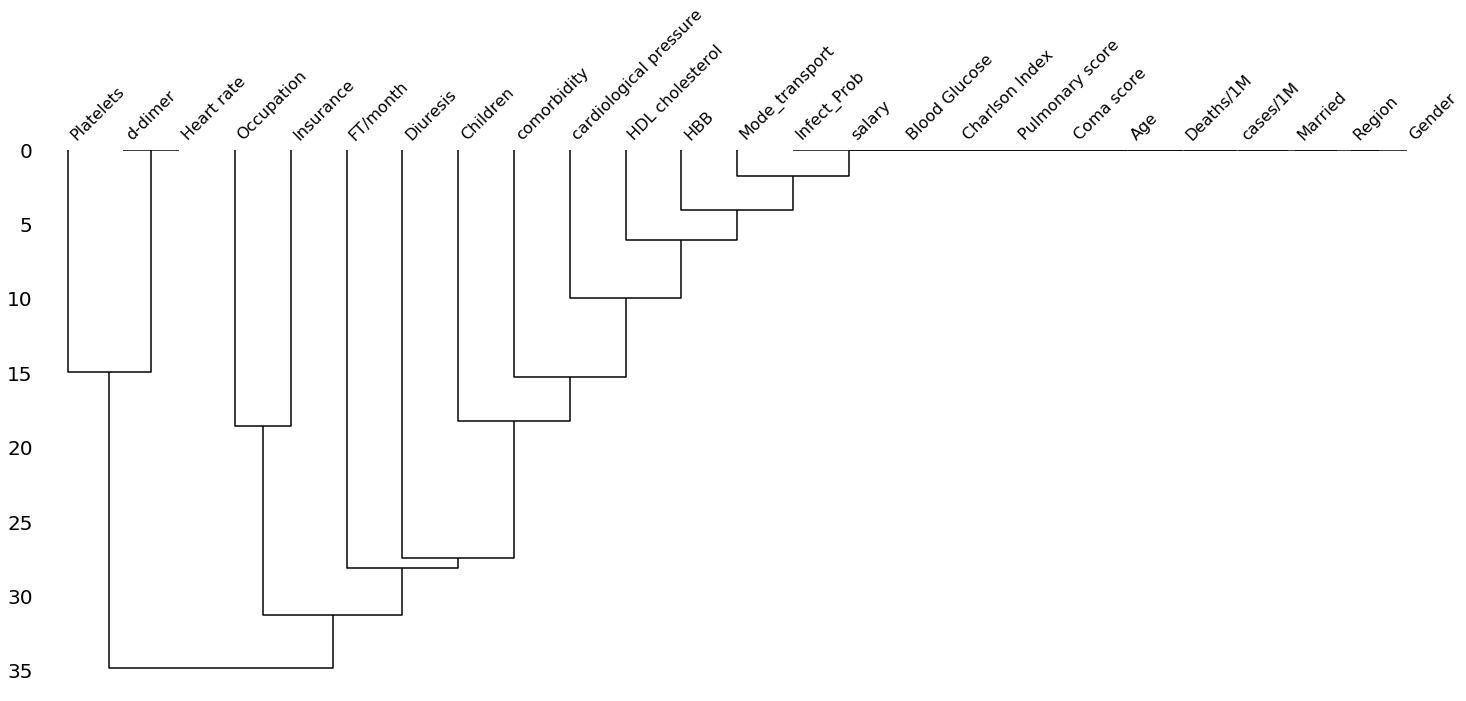

In [37]:
msno.dendrogram(train_copy);

## 2.3 Handling the Missing values
- We going to deal with the numerical missing data and categorical missing data differently

In [38]:
# how many missing values each col has
for col in train_df.columns:
    print(train_df[col].isnull().values.sum())

0
0
0
311
747
3
0
0
226
0
0
0
97
716
924
16
1114
1114
35
0
0
1090
0
723
0


In [40]:
num_train = train_df.select_dtypes(include='number')
cat_train = train_df.select_dtypes(exclude='number')

In [41]:
num_test = test_df.select_dtypes(include='number');
cat_test = test_df.select_dtypes(exclude='number');

In [42]:
print(f'{train_df.shape[1] == num_train.shape[1] + cat_train.shape[1]}')

True


### 2.3.1 Numerical NaNs

In [43]:
from sklearn.impute import SimpleImputer

In [44]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [45]:
for col in num_train:
    train_df[[col]] = imputer.fit_transform(train_df[[col]])

### 2.3.2 Categorical NaNs

In [46]:
imputer = SimpleImputer(strategy='most_frequent')

In [47]:
for col in cat_train:
    train_df[[col]] = imputer.fit_transform(train_df[[col]])  

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 25 columns):
Region                    10714 non-null object
Gender                    10714 non-null object
Married                   10714 non-null object
Children                  10714 non-null float64
Occupation                10714 non-null object
Mode_transport            10714 non-null object
cases/1M                  10714 non-null float64
Deaths/1M                 10714 non-null float64
comorbidity               10714 non-null object
Age                       10714 non-null float64
Coma score                10714 non-null float64
Pulmonary score           10714 non-null object
cardiological pressure    10714 non-null object
Diuresis                  10714 non-null float64
Platelets                 10714 non-null float64
HBB                       10714 non-null float64
d-dimer                   10714 non-null float64
Heart rate                10714 non-null float64
HDL cholesterol  

In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14498 entries, 0 to 14497
Data columns (total 24 columns):
Region                    14498 non-null object
Gender                    14498 non-null object
Married                   14498 non-null object
Children                  14498 non-null int64
Occupation                14498 non-null object
Mode_transport            14498 non-null object
cases/1M                  14498 non-null int64
Deaths/1M                 14498 non-null int64
comorbidity               14498 non-null object
Age                       14498 non-null int64
Coma score                14498 non-null int64
Pulmonary score           14498 non-null object
cardiological pressure    14498 non-null object
Diuresis                  14498 non-null int64
Platelets                 14498 non-null int64
HBB                       14498 non-null int64
d-dimer                   14498 non-null int64
Heart rate                14498 non-null int64
HDL cholesterol           14498 non-n

## 2.4 Pair Visualization

In [50]:
x_vars = train_df.columns[:-1]
y_vars = train_df.columns[-1]

In [51]:
# this is a pretty resource consuming plot hence avoid it untill you have enough memory and processing power
# sns.pairplot(train_df, x_vars=x_vars, y_vars=y_vars, diag_kind="kde", hue='Gender');

In [52]:
# from the above plot we can drive many conclusion such that Infect_Prob is 
# lower among Married folks similarly we can drive many conclusion

## 2.5 Dealing with Categorical Data

In [54]:
from sklearn.preprocessing import LabelEncoder

In [55]:
Y = train_df.Infect_Prob
X = train_df.drop(columns=['Infect_Prob'], axis=1)

In [56]:
encoder = LabelEncoder()
# encoder = ce.BackwardDifferenceEncoder(cols=[...])
# encoder = ce.BaseNEncoder(cols=[...])
# encoder = ce.BinaryEncoder(cols=[...])
# encoder = ce.CatBoostEncoder(cols=[...])
# encoder = ce.HashingEncoder(cols=[...])
# encoder = ce.HelmertEncoder(cols=[...])
# encoder = ce.JamesSteinEncoder(cols=[...])
# encoder = ce.LeaveOneOutEncoder(cols=[...])
# encoder = ce.MEstimateEncoder(cols=[...])
# encoder = ce.OrdinalEncoder(cols=[...])
# encoder = ce.SumEncoder(cols=[...])
# encoder = ce.PolynomialEncoder(cols=[...])
# encoder = ce.TargetEncoder(cols=[...])
# encoder = ce.WOEEncoder(cols=[...])

In [57]:
for col in cat_train:
    X[col]  = encoder.fit_transform(X[col])
    

In [58]:
for col in cat_test:
    test_df[col] = encoder.fit_transform(test_df[col])

In [59]:
X.head()

,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,...,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month
0,1,0,1,1.0,4,1,2.0,0.0,2,68.0,...,154.0,93.0,233.0,82.0,58.0,27.0,7.0,3600000.0,1300000.0,2.0
1,1,0,1,2.0,4,2,2.0,0.0,1,64.0,...,121.0,56.0,328.0,89.0,68.0,5.0,6.0,1600000.0,400000.0,1.0
2,1,0,0,1.0,1,1,2.0,0.0,3,19.0,...,124.0,137.0,213.0,77.0,43.0,40.0,6.0,3400000.0,900000.0,1.0
3,1,0,1,1.0,3,0,2.0,0.0,0,33.0,...,98.0,167.0,275.0,64.0,60.0,27.0,7.0,700000.0,2300000.0,1.0
4,1,0,0,2.0,6,0,2.0,0.0,1,23.0,...,21.0,153.0,331.0,71.0,64.0,32.0,7.0,3200000.0,1100000.0,1.0


In [267]:
test_df['Pulmonary score']

0        1
1        1
2        0
3        2
4        1
        ..
14493    3
14494    2
14495    2
14496    1
14497    1
Name: Pulmonary score, Length: 14498, dtype: int32

In [268]:
x_vars = X.columns[:-1]
y_vars = X.columns[-1]

In [60]:
# X['Diuresis']

0        441.0
1        276.0
2        416.0
3        410.0
4        390.0
         ...  
10709    134.0
10710    387.0
10711    177.0
10712    352.0
10713    181.0
Name: Diuresis, Length: 10714, dtype: float64

## Replacing the Old 'Diuresis' with New 'Diuresis' values on 27-03-2020 predicted by the time series model.
- Infect_prob prediction with Diuresis(on 27-03-2020) predicted by the time series model

In [62]:
new_diuresis_df =  pd.read_csv("../predictions/covid19_time_series_task-1.csv")["2020-03-27"]

In [65]:
X_new = X

In [66]:
X_new.Diuresis[:5]

0    441.0
1    276.0
2    416.0
3    410.0
4    390.0
Name: Diuresis, dtype: float64

In [67]:
# replacing the old_diuresis with new diuresis 
X_new.Diuresis = new_diuresis_df 

In [68]:
X_new.Diuresis[:5]

0    1650.2976
1     676.8725
2    1551.8610
3    1497.7036
4    1450.7468
Name: Diuresis, dtype: float64

# 2. Data Pipeline

In [70]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [200]:
X = preprocessing.normalize(X, axis=1)
X_new = preprocessing.normalize(X_new, axis=1)

In [84]:
X_train, X_val, Y_train, Y_val = train_test_split(X,  Y.values, test_size=0.1, random_state=42)
X_new_train, X_new_val, Y_new_train, Y_new_val = train_test_split(X_new,  Y.values, test_size=0.15, random_state=42)

In [85]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
print(X_new_train.shape, X_new_val.shape, Y_new_train.shape, Y_new_val.shape)

(9642, 24) (1072, 24) (9642,) (1072,)
(9106, 24) (1608, 24) (9106,) (1608,)


In [82]:
# X_new.Diuresis

0        1650.29760
1         676.87250
2        1551.86100
3        1497.70360
4        1450.74680
            ...    
10709     638.13370
10710    1430.85410
10711     769.66376
10712    1347.92520
10713     764.40564
Name: Diuresis, Length: 10714, dtype: float64

In [204]:
# preprocessing.axis([[10, 2, 30]], axis=0)

# 3. Models and Training

In [122]:
def dnn():
    model  = Sequential()
    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse',metrics=[r2_score])
    return model
    

In [125]:
model = dnn()

In [128]:
# traing 
# history = model.fit(X_train,Y_train,epochs=50,validation_data=(X_val,Y_val),verbose=1)

In [61]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

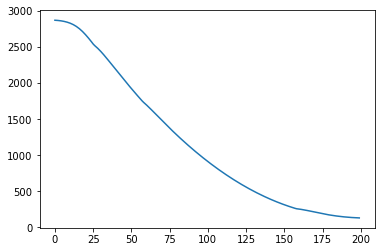

In [65]:
plt.plot(val_loss, label="val_loss")
plt.show()

In [74]:
def r2_score(y_true,y_pred):
    num = K.sum(K.square(y_true-y_pred))
    denom = K.sum(K.square(y_true- K.mean(y_true)))
    return (1-num/denom)

In [75]:
Y_val[:10]

array([47.30837595, 48.97426018, 47.28339403, 46.97029262, 97.632     ,
       45.27885255, 49.24589749, 41.98176   , 46.3032033 , 45.88704   ])

### Boosting Models

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

### Fit the model on both with X and X_new (diuresis values on 27-03-2020)

In [86]:
grad_boost = GradientBoostingRegressor(
                n_estimators=100, 
                learning_rate=0.1, 
                max_depth=10, 
                random_state=12, 
                loss='ls').fit(X_train, Y_train)
grad_boost_new = GradientBoostingRegressor(
                n_estimators=100, 
                learning_rate=0.1, 
                max_depth=10, 
                random_state=12, 
                loss='ls').fit(X_new_train, Y_new_train)

In [87]:
ada_boost = AdaBoostRegressor(random_state=10, n_estimators=100).fit(X_train, Y_train)
ada_boost_new = AdaBoostRegressor(random_state=10, n_estimators=100).fit(X_new_train, Y_new_train)

In [89]:
print(f'Training score:\n grad_boost_r2score = {grad_boost.score(X_train, Y_train)} \n ada_boost_r2score = {ada_boost.score(X_train, Y_train)}')
print(f'Validation score:\n grad_boost_r2score = {grad_boost.score(X_val, Y_val)} \n ada_boost_r2score = {ada_boost.score(X_val, Y_val)}')

print(f'\n\nTraining score(with new diuresis):\n grad_boost_r2score = {grad_boost_new.score(X_new_train, Y_new_train)} \n ada_boost_r2score = {ada_boost_new.score(X_new_train, Y_new_train)}')
print(f'Validation score(with new diuresis):\n grad_boost_r2score = {grad_boost_new.score(X_new_val, Y_new_val)} \n ada_boost_r2score = {ada_boost_new.score(X_new_val, Y_new_val)}')

Training score:
 grad_boost_r2score = 0.9987531949415611 
 ada_boost_r2score = 0.32741505852492614
Validation score:
 grad_boost_r2score = 0.1958509559216587 
 ada_boost_r2score = 0.26988218898283267


Training score(with new diuresis):
 grad_boost_r2score = 0.9994291080165075 
 ada_boost_r2score = 0.33085351755938885
Validation score(with new diuresis):
 grad_boost_r2score = 0.20559404286738758 
 ada_boost_r2score = 0.2777185503004779


In [90]:
list(grad_boost_new.predict(X_new_val)[100:110])

[49.06651841770389,
 58.86092895157576,
 46.5138125359507,
 69.00323000232808,
 52.46286847623698,
 49.699320063597575,
 48.56616293563284,
 48.04562842215019,
 46.77002408493933,
 49.765578032279016]

In [91]:
list(ada_boost_new.predict(X_new_val)[100:110])

[49.12445666770345,
 63.957905340314106,
 46.87965504449524,
 63.957905340314106,
 55.8928782205355,
 49.14228803178531,
 49.12445666770345,
 49.12445666770345,
 46.87965504449524,
 49.14228803178531]

In [92]:
list(Y_new_val[100:110])

[49.3814598,
 38.07648,
 46.37133441,
 93.72672,
 52.35127748,
 49.9163627,
 48.35860012,
 48.30335398,
 46.6405469,
 49.70742401]

In [101]:
# grad_boost_new.predict(test_df.values)

### Conclusion: Gradient Boosting Regressor perfroms better

### Inference

In [97]:
people_ID =  pd.read_csv("../predictions/covid19_time_series_task-1.csv")["people_ID"]

In [93]:
preds = grad_boost.predict(test_df.values)
preds_new = grad_boost_new.predict(test_df.values)

In [95]:
preds_df = pd.DataFrame(data=preds, columns=['Infect_prob'])
preds_new_df = pd.DataFrame(data=preds_new, columns=['Infect_prob(on 27-03-2020 Diuresis values)'])

In [98]:
result = pd.concat([people_ID, preds_df], axis=1)
result_new = pd.concat([people_ID, preds_new_df], axis=1)

In [99]:
result_new.to_csv('infect_prob(on 27-03-2020 Diuresis values).csv', index=False)

### What could be done to improve the result
- More Feature Engineering
    - From the dendrogram we can see that some features have very little to no impact(zero correlation) on dependent variable Infect_prob one can do the manuever by removing them and training the models again
    - Another good practice for such task is eliminating the outliers
- More Models
    - We can fit more models and see the results
- Preprocessing
    - We could use grid search to find best strategy for imputation and Categorical Data Encoder(listed in cell)
    

### Infect_prob prediction with Diuresis(on 27-03-2020) predicted by the time series model

In [14]:
new_diuresis_df =  pd.read_csv("../predictions/covid19_time_series_task-1.csv")["2020-03-27"]

In [15]:
new_diuresis_df.head()

0    1650.2976
1     676.8725
2    1551.8610
3    1497.7036
4    1450.7468
Name: 2020-03-27, dtype: float64

### Replacing the diuresis with this one in the train_df and rest of the code will be same

In [17]:
train_df['Diuresis'] = new_diuresis_df

In [22]:
train_copy['Diuresis']

0        1650.29760
1         676.87250
2        1551.86100
3        1497.70360
4        1450.74680
            ...    
10709     638.13370
10710    1430.85410
10711     769.66376
10712    1347.92520
10713     764.40564
Name: Diuresis, Length: 10714, dtype: float64

In [23]:
train_df['Diuresis']

0        1650.29760
1         676.87250
2        1551.86100
3        1497.70360
4        1450.74680
            ...    
10709     638.13370
10710    1430.85410
10711     769.66376
10712    1347.92520
10713     764.40564
Name: Diuresis, Length: 10714, dtype: float64